# Interpreting the results of PSID when applied to M1 data during a center-out reaching task

In this notebook, we apply PSID to population activity taken from the primary motor cortex (M1) during a center-out reaching task. The data was gathered from a previously published monkey reaching experiment (Gallego et al. 2020). In this experiment, the monkey is trained to perform a center-out reaching task with eight outer targets. On a go cue, the monkey moves a manipulandum along a 2D plane to the presented target and receives a liquid reward upon success. Spiking activity from M1 along with the 2D hand position are recorded during each trial.

(Thanks Omid Sani for helping me create this notebook by providing code).

In [1]:
!pip install PSID --upgrade

  Using cached PSID-1.1.0-py3-none-any.whl (19 kB)
  Attempting uninstall: PSID
    Found existing installation: PSID 1.0.6
    Uninstalling PSID-1.0.6:
      Successfully uninstalled PSID-1.0.6
You should consider upgrading via the '/disk_c/cole/miniconda3/envs/pytorch3d_update/bin/python -m pip install --upgrade pip' command.


In [1]:
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
from matplotlib import patches
import PSID
from PSID.evaluation import evalPrediction
from PSID.MatHelper import loadmat
import utils

from plotting import plot_psid_2_factors

# Loading, preprocessing, and visualizing data

The data consist of 136 training trials and 17 testing trials. Each trial has 730 ms of neural/behavioural data which is sampled in 10 ms bins. The behavioural data consists of 2D hand position during reaches in 8 different directions.

To preprocess the data, we perform the following steps

1. Smooth neural data using Gaussian filter with std. 50 ms.
2. Center both the neural and behavioural data by subtracting the mean.

In [2]:
dataset ='Chewie_CO_FF_2016-10-07_pos_M1_spikes'
data_dir = "data_0.h5"
ground_truth_data_dict = utils.read_data('../plfads/exp_data' + '/' + dataset + '/' + data_dir)

In [3]:
ground_truth_train_rates = ground_truth_data_dict['train_rates']
ground_truth_test_rates = ground_truth_data_dict['test_rates']
ground_truth_valid_rates = ground_truth_data_dict['valid_rates']
ground_truth_train_behaviours = ground_truth_data_dict['train_behaviours']
ground_truth_test_behaviours = ground_truth_data_dict['test_behaviours']
ground_truth_valid_behaviours = ground_truth_data_dict['valid_behaviours']


all_directions_dict = ground_truth_data_dict['train_target_direction']
d = ground_truth_data_dict['test_target_direction']
direction_index_test = [sorted(set(all_directions_dict)).index(i) for i in d]
d = ground_truth_data_dict['train_target_direction']
direction_index_train = [sorted(set(all_directions_dict)).index(i) for i in d]
d = ground_truth_data_dict['valid_target_direction']
direction_index_valid = [sorted(set(all_directions_dict)).index(i) for i in d]

print("Train rates shape", ground_truth_train_rates.shape)
print("Test rates shape", ground_truth_test_rates.shape)
print("Train behaviours shape", ground_truth_train_behaviours.shape)
print("Test behaviours shape", ground_truth_test_behaviours.shape)

import scipy
bins_smooth = 5 # 50 ms. std. deviation Gaussian smoothing
directions = range(8)
smoothed_train_rates = scipy.ndimage.gaussian_filter1d(ground_truth_train_rates.astype(float), sigma=bins_smooth, axis=1)[np.in1d(np.asarray(direction_index_train), directions)]
smoothed_test_rates = scipy.ndimage.gaussian_filter1d(ground_truth_test_rates.astype(float), sigma=bins_smooth, axis=1)[np.in1d(np.asarray(direction_index_test), directions)]
smoothed_valid_rates = scipy.ndimage.gaussian_filter1d(ground_truth_valid_rates.astype(float), sigma=bins_smooth, axis=1)[np.in1d(np.asarray(direction_index_valid), directions)]

ground_truth_train_behaviours = ground_truth_train_behaviours[np.in1d(np.asarray(direction_index_train), directions)]

Train rates shape (136, 73, 70)
Test rates shape (17, 73, 70)
Train behaviours shape (136, 73, 2)
Test behaviours shape (17, 73, 2)


In [4]:
use_smoothed_spike_counts = True # Set this to False to do smoothing and just model the original spike counts with PSID, which also works fine
if not use_smoothed_spike_counts: 
    smoothed_train_rates = ground_truth_train_rates
    smoothed_test_rates = ground_truth_test_rates
    smoothed_valid_rates = ground_truth_valid_rates

YCat = np.concatenate(smoothed_train_rates)
ZCat = np.concatenate(ground_truth_train_behaviours)

YMean = np.mean(YCat, axis=0)
ZMean = np.mean(ZCat, axis=0)
remove_mean = True # THIS MUST BE TRUE (option is provide just for reference, to see what happens when this is False and the necessary mean removal is not performed)
if not remove_mean:
    YMean *= 0
    ZMean *= 0
    
Y = list(smoothed_train_rates) 
Z = list(ground_truth_train_behaviours)

Y = [YThis-YMean for YThis in Y] # [Important:] Mean of data must be removed from each trial before PSID modeling, and added back to predictions later if needed
Z = [ZThis-ZMean for ZThis in Z] # [Important:] Mean of data must be removed from each trial before PSID modeling, and added back to predictions later if needed

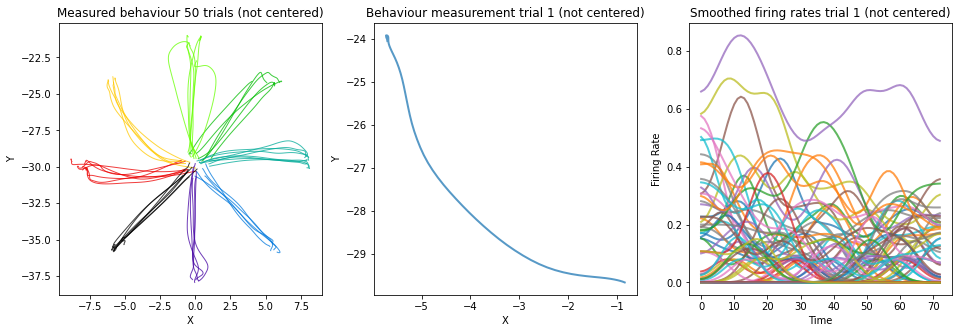

In [5]:
#Visualize dataset
plt.figure(figsize=(16,5))
colors = plt.cm.nipy_spectral(np.arange(8)/8)

n_show = 50
t_show = ground_truth_train_behaviours.shape[1]
dirs_show = set([0,1,2,3,4,5,6,7])

plt.subplot(1,3,1)
for t in range(n_show):
    if direction_index_train[t] in dirs_show:
        plt.plot(ground_truth_train_behaviours[t,:t_show,0], ground_truth_train_behaviours[t,:t_show,1],color=colors[direction_index_train[t]],alpha=.75, lw=1)
plt.title('Measured behaviour 50 trials (not centered)')
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(1,3,2)
plt.plot(ground_truth_train_behaviours[1,:t_show, 0], ground_truth_train_behaviours[1,:t_show,1], alpha=.75,lw=2)
plt.title('Behaviour measurement trial 1 (not centered)')
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(1,3,3)
plt.plot(smoothed_train_rates[1,:t_show,:],alpha=.75,lw=2)
plt.title('Smoothed firing rates trial 1 (not centered)')
plt.xlabel('Time')
plt.ylabel('Firing Rate');

# Learning and inference with PSID on the dataset

PSID is a linear dynamical model that simultaneously models behaviour and neural activity. The model can be defined as below (taken from PSID tutorial https://github.com/ShanechiLab/PyPSID/blob/main/source/PSID/example/PSID_tutorial.ipynb):

$$ x_{k+1} = A x_k + w_k $$   

$$ y_k = C_y x_k + v_k $$

$$ z_k = C_z x_k + \epsilon_k $$ 

where $y_k \in \!R^{n_y}$ is the neural activity, $z_k \in \!R^{n_z}$ is the behavior, and $x_k \in \!R^{n_x}$ is the latent state the describes the dynamics in both. The latent states, $x_k$ are defined as:

$$
x_k = \begin{bmatrix}
x_k^{(1)} \\
x_k^{(2)}
\end{bmatrix}
$$

where the behaviorally relevant dimensions of latent state ($x_k^{(1)} \in \!R^{n_1}$), which are those that drive $z_k$, are separated from the other dimensions ($x_k^{(2)} \in \!R^{n_2}$ with $n_2=n_x-n_1$). PSID learns the model parameters $A$, $C_y$, and $C_z$ (and other parameters) through a two-stage subspace identification learning process defined in Sani et al. 2021. Critically, according to Sani et al. 2021, the learned state-transition matrix A "[characterizes] the behaviorally relevant neural dynamics". Therefore, in this notebook, we will examine the learned dynamics of PSID by analyzing the state-transition matrix A.

In [6]:
#LEARNING: fitting the model (n1 is the number of behaviourally relevant states and nx is the total number of states)
idSys1 = PSID.PSID(Y, Z, nx=2, n1=2, i=10)

In [21]:
""" Function created by Omid Sani"""
def PSIDPredictForTrials(idSys, YAll, YMean=None, ZMean=None, steady_state=True, useKalmanSmoother=False):
    zPredAll, yPredAll, xPredAll = [], [], []
    for ti in range(len(YAll)):
        yThis = YAll[ti]
        
        # Predict behavior, rates, and latents using the learned model
        if not useKalmanSmoother:
            # zPred1This, yPred1This, xPred1This = idSys.predict(yThis-YMean) # Subtract the mean of Y (learned form training data)
            # We can directly use the kalman function to also enable control over whether steady-state or time-varying kalman filter is used
            allXp1, allYp1, allXf1 = idSys.kalman(yThis-YMean, steady_state=steady_state)
            xPred1This = allXp1
        else:
            # Directly use the kalman function and then use the smoother pass from the pykalman library
            # You will need to install pykalman: 
            # pip install pykalman
            from pykalman.standard import _smooth
            allXp1, allYp1, allXf1, allPp1, allPf1 = idSys.kalman(yThis-YMean, steady_state=False, return_state_cov=True)
            smoothed_state_means3, _, _ = _smooth( transition_matrices=idSys.A, 
                    filtered_state_means=allXf1, filtered_state_covariances=allPf1, 
                    predicted_state_means=allXp1, predicted_state_covariances=allPp1)
            xPred1This = smoothed_state_means3
        yPred1This = allYp1
        zPred1This = (idSys.Cz @ xPred1This.T).T

        yPred1This = yPred1This + YMean  # Add back the mean of Y (learned from training data)
        zPred1This = zPred1This + ZMean  # Add back the mean of Z (learned from training data)
        zPredAll.append(zPred1This)
        yPredAll.append(yPred1This)
        xPredAll.append(xPred1This)
    return zPredAll, yPredAll, xPredAll

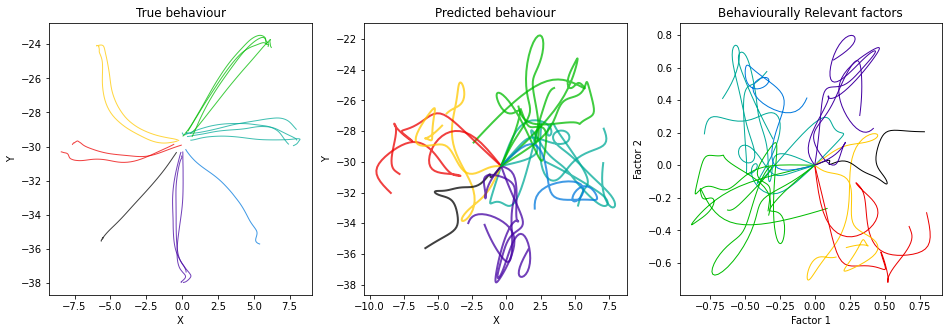

In [22]:
useKalmanSmoother = False
zPredTest, yPredTest, xPredTest = PSIDPredictForTrials(idSys1, smoothed_test_rates, YMean, ZMean, useKalmanSmoother=useKalmanSmoother)

factors = xPredTest
behaviour_means = zPredTest
rate_means = yPredTest

latents = np.asarray(factors)
dir_index = direction_index_test
ground_truth_behaviours = ground_truth_test_behaviours
predicted_behaviours = np.asarray(behaviour_means)

plot_psid_2_factors(latents, dir_index, ground_truth_behaviours, predicted_behaviours);

In [23]:
#Evaluating the behaviour prediction
from sklearn.metrics import r2_score, mean_squared_error
trueCat = np.concatenate(ground_truth_test_behaviours)
predCat = np.concatenate(predicted_behaviours)
print("Behaviour R2:", r2_score(trueCat, predCat))
print("Behaviour MSE:", mean_squared_error(trueCat, predCat))

Behaviour R2: 0.7490891786324945
Behaviour MSE: 4.244907008396508


# Interpreting the identified model parameters (state-transition matrix $A$)

From the above visualization, one can see that PSID's latent factors (inferred with the Kalman filter) contain information about the behaviour. To interpret the learned dynamics, we will examine the state-transition matrix $A$ and its eigenvalues.

In [24]:
# #########################################
A = idSys1.A
# Eigenvalues when only learning behaviorally relevant states
idEigs1 = np.linalg.eig(idSys1.A)[0]

print("A: ", idSys1.A)
print()
print("Eigenvalues: ", np.linalg.eig(idSys1.A)[0])

A:  [[1. 0.]
 [0. 1.]]

Eigenvalues:  [1. 1.]


Interestingly, **we find that the state-transition matrix $A$ for PSID is approximately the identity matrix when applied to our dataset**. This would imply that the learned behavioural dynamics predict that the latent state won't change over the course of the trial!

# Is the state-transition matrix $A$ basically the identity for our dataset? (Answer: yes)
Although the $A$ matrix is approximately the identity, we can see that the diagonal terms are slightly larger than one and the eigenvalues are complex, implying there is a slight outward rotation to the dynamics. To understand if the dynamics learned by the state-transition matrix are truly different than the identity matrix, we can replace the $A$ matrix with the identity and re-run the Kalman filter inference.

A:  [[1. 0.]
 [0. 1.]]

Eigenvalues:  [1. 1.]


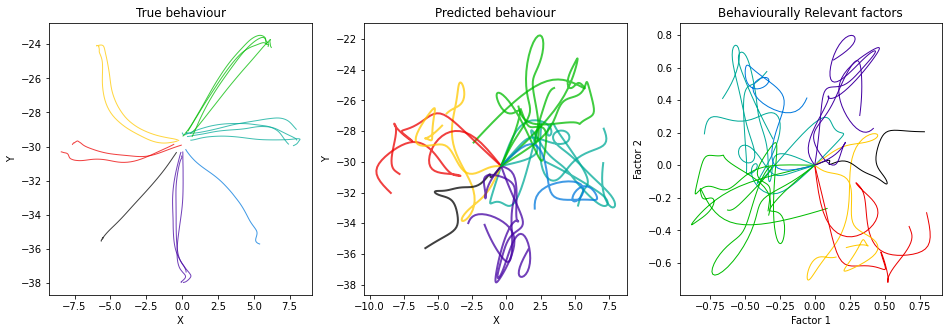

In [25]:
#Re-run inference when A is set to the identity. We purposefully do not update the other parameters to measure the effect that A has on the inferred latent states.
idSys1.A = np.eye(2) # Replace A matrix with identity and do not update other params
print("A: ", idSys1.A)
print()
print("Eigenvalues: ", np.linalg.eig(idSys1.A)[0])
zPredTest, yPredTest, xPredTest = PSIDPredictForTrials(idSys1, smoothed_test_rates, YMean, ZMean, useKalmanSmoother=useKalmanSmoother)

factors = xPredTest
behaviour_means = zPredTest
rate_means = yPredTest

latents = np.asarray(factors)
dir_index = direction_index_test
ground_truth_behaviours = ground_truth_test_behaviours
predicted_behaviours = np.asarray(behaviour_means)

#Visualize results
plot_psid_2_factors(latents, dir_index, ground_truth_behaviours, predicted_behaviours);

In [26]:
#Evaluating the behaviour prediction
from sklearn.metrics import r2_score, mean_squared_error
trueCat = np.concatenate(ground_truth_test_behaviours)
predCat = np.concatenate(np.asarray(zPredTest))
print("Behaviour R2:", r2_score(trueCat, predCat))
print("Behaviour MSE:", mean_squared_error(trueCat, predCat))

Behaviour R2: 0.7490891786324945
Behaviour MSE: 4.244907008396508


As can be seen, the shape of the behaviourally releant dynamics is nearly identical to the dynamics predicted by PSID with the previous A matrix. Also, the behaviour decoding is virtually the same. **This implies that the A matrix is basically the identity for our dataset.** To understand what this prediction means, we can perform further analysis.

# We get same $A$ matrix (identity) when applying PSID to a shuffled dataset
To understand if the A matrix is telling us something interesting about the neural data, we will test if the dynamics are preserved after shuffling the dataset. We will shuffle the neural data in two different ways:

1. Shuffle by trial.
2. Shuffle in time.

A:  [[ 1.01522962  0.0033971 ]
 [-0.00092854  1.0132002 ]]

Eigenvalues:  [1.01421491+0.00145764j 1.01421491-0.00145764j]


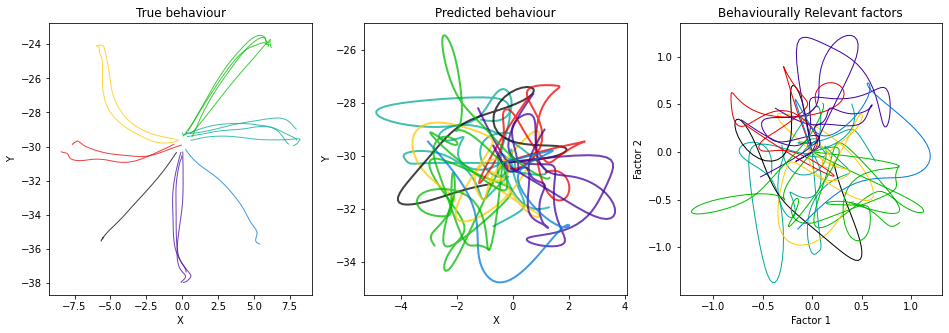

In [27]:
#shuffle by trial
import random
random.seed(31)
#Shuffle the neural data list by trial
Y_shuffled = random.sample(Y, len(Y))
#refit PSID
idSys2 = PSID.PSID(Y_shuffled, Z, nx=2, n1=2, i=10)

A = idSys2.A
# Eigenvalues when only learning behaviorally relevant states
idEigs2 = np.linalg.eig(idSys2.A)[0]

print("A: ", idSys2.A)
print()
print("Eigenvalues: ", np.linalg.eig(idSys2.A)[0])

#Run inference for the shuffled dataset
zPredTest, yPredTest, xPredTest = PSIDPredictForTrials(idSys2, smoothed_test_rates, YMean, ZMean, useKalmanSmoother=useKalmanSmoother)

factors = xPredTest
behaviour_means = zPredTest
rate_means = yPredTest

latents = np.asarray(factors)
dir_index = direction_index_test
ground_truth_behaviours = ground_truth_test_behaviours
predicted_behaviours = np.asarray(behaviour_means)

#Visualize results
plot_psid_2_factors(latents, dir_index, ground_truth_behaviours, predicted_behaviours);

In [28]:
#Evaluating the behaviour prediction
from sklearn.metrics import r2_score, mean_squared_error
trueCat = np.concatenate(ground_truth_test_behaviours)
predCat = np.concatenate(predicted_behaviours)
print("Behaviour R2:", r2_score(trueCat, predCat))
print("Behaviour MSE:", mean_squared_error(trueCat, predCat))

Behaviour R2: -0.276866209929306
Behaviour MSE: 22.583435949106182


RESULT: We again find that the A matrix is the approximately the identity with a slight rotation (off diagonal positive and negative) after shuffling by trial. The behaviour decoding is quite bad, but the dynamics are the same as the original PSID results!

A:  [[ 1.01494357  0.00185159]
 [-0.00134494  1.01861746]]

Eigenvalues:  [1.01584025 1.01772078]


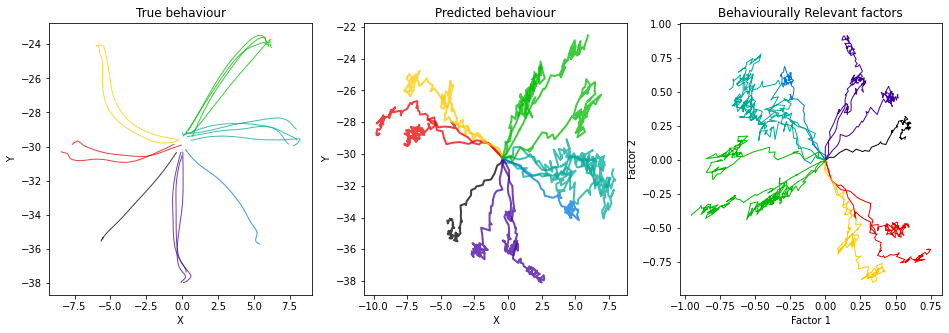

In [29]:
#shuffle in time
np.random.seed(0)
Y_copy = np.copy(Y)
[np.random.shuffle(x) for x in Y_copy] #shuffle inplace over time
Y_shuffled_time = list(Y_copy)
#refit PSID
idSys3 = PSID.PSID(Y_shuffled_time, Z, nx=2, n1=2, i=10)

A = idSys3.A
print("A: ", idSys3.A)
print()
print("Eigenvalues: ", np.linalg.eig(idSys3.A)[0])

smoothed_test_rates_copy = np.copy(smoothed_test_rates)
[np.random.shuffle(x) for x in smoothed_test_rates_copy]
# [np.random.shuffle(x) for x in smoothed_test_rates_copy]
# [np.random.shuffle(x) for x in smoothed_test_rates_copy]
#Run inference for the shuffled dataset
zPredTest, yPredTest, xPredTest = PSIDPredictForTrials(idSys3, smoothed_test_rates_copy, YMean, ZMean, useKalmanSmoother=useKalmanSmoother)

factors = xPredTest
behaviour_means = zPredTest
rate_means = yPredTest

latents = np.asarray(factors)
dir_index = direction_index_test
ground_truth_behaviours = ground_truth_test_behaviours
predicted_behaviours = np.asarray(behaviour_means)

#Visualize results
plot_psid_2_factors(latents, dir_index, ground_truth_behaviours, predicted_behaviours);

In [30]:
#Evaluating the behaviour prediction
from sklearn.metrics import r2_score, mean_squared_error
trueCat = np.concatenate(ground_truth_test_behaviours)
predCat = np.concatenate(predicted_behaviours)
print("Behaviour R2:", r2_score(trueCat, predCat))
print("Behaviour MSE:", mean_squared_error(trueCat, predCat))

Behaviour R2: 0.7940081808325263
Behaviour MSE: 3.5264285570591145


RESULT: We find that the A matrix is the approximately the identity with a slight rotation (off diagonal positive and negative) after shuffling in time. Also, the behaviour decoding is quite good despite the neural data being completly shuffled over time!

# Why is the A matrix the identity (Answer: Because of the non-linearity of the behaviour across trials)

The question is, why is the $A$ matrix the identity? Our hypothesis for this phenomena that the behaviour is nonlinear over all trials (8 different directions) so PSID will have a hard time modelling this nonlinearity (PSID is a purely linear method). To test this hypohtesis, we can try running PSID on a variable number of reach directions and see when the state-transition matrix A collapses to the identity.

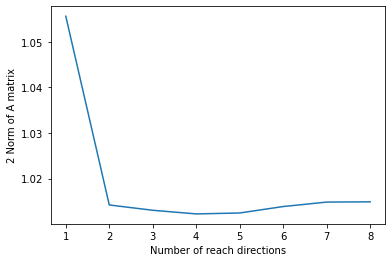

In [31]:
#run PSID on a variable number of reach directions and measure the state-transition matrix A norm to see if it collapses to the identity.
all_num_directions = [1,2,3,4,5,6,7,8]
A_norms = []
for num_directions in all_num_directions:
    curr_directions = directions[:num_directions]
    smoothed_train_rates = scipy.ndimage.gaussian_filter1d(ground_truth_train_rates.astype(float), sigma=bins_smooth, axis=1)[np.in1d(np.asarray(direction_index_train), curr_directions)]
    smoothed_test_rates = scipy.ndimage.gaussian_filter1d(ground_truth_test_rates.astype(float), sigma=bins_smooth, axis=1)[np.in1d(np.asarray(direction_index_test), curr_directions)]
    curr_ground_truth_train_behaviours = ground_truth_train_behaviours[np.in1d(np.asarray(direction_index_train), curr_directions)]

    use_smoothed_spike_counts = True # Set this to False to do smoothing and just model the original spike counts with PSID, which also works fine
    if not use_smoothed_spike_counts: 
        smoothed_train_rates = ground_truth_train_rates
        smoothed_test_rates = ground_truth_test_rates

    YCat = np.concatenate(smoothed_train_rates)
    ZCat = np.concatenate(curr_ground_truth_train_behaviours)

    YMean = np.mean(YCat, axis=0)
    ZMean = np.mean(ZCat, axis=0)
    remove_mean = True # THIS MUST BE TRUE (option is provide just for reference, to see what happens when this is False and the necessary mean removal is not performed)
    if not remove_mean:
        YMean *= 0
        ZMean *= 0

    Y = list(smoothed_train_rates) 
    Z = list(curr_ground_truth_train_behaviours)

    Y = [YThis-YMean for YThis in Y] # [Important:] Mean of data must be removed from each trial before PSID modeling, and added back to predictions later if needed
    Z = [ZThis-ZMean for ZThis in Z] # [Important:] Mean of data must be removed from each trial before PSID modeling, and added back to predictions later if needed
    
    #LEARNING: fitting the model (n1 is the number of behaviourally relevant states and nx is the total number of states)
    idSys_dir = PSID.PSID(Y, Z, nx=2, n1=2, i=10)
    A_norms.append(scipy.linalg.norm(idSys_dir.A, ord=2))
plt.plot(all_num_directions, A_norms)
plt.ylabel('2 Norm of A matrix')
plt.xlabel('Number of reach directions');

RESULT: If the number of reaches is greater than 1, the A matrix approaches the identity matrix. Only when the there is only one reach direction does the A matrix do something different.

CONCLUSION. The A matrix (and therefore, PSID) appears to be uninformative about the dataset because the behaviour is non-linear across trials.

## Does the behaviour prediction of PSID perform better than a purely behavioural baseline?
Extracting the behaviourally relevant neural dynamics using PSID consists of the following steps (from the Omid et al. 2021):


1. Form examples of future behavior ($Z_f$) and the associated past neural activity ($Y_p$) and then project the former onto the latter ($\hat{Z}$).

2. Compute the singular value decomposition (SVD) of $\hat{Z}$ = $USV^\intercal \approx U_1S_1{V_1}^\intercal$ and keep the top n1 singular values:

3. Compute the behaviorally relevant latent state $\hat{X}$ as $\hat{X} = S_1{V_1}^\intercal$


The question is, does PSID perform better than a purely behavioural version of their method. In other words, what happens if we replace the projection $\hat{Z}$ with the actual behaviour $Z_f$ and perform step 3 to extract the latent states (we will call this modifed latent state $\hat{X_b}$)?. To perform this operation, we modify the original PSID code to replace the projections of behaviour onto neural activity with just the behaviour. We will import this modified PSID code in the next cell.

In [32]:
import sys
sys.path.insert(0,'/home/cole/psid_technical_report/PyPSID_bo/source')
import PSID_bo #bo=behaviour only

In [33]:
idSys4 = PSID_bo.PSID_bo(Y, Z, nx=2, n1=2, i=10)

In [34]:
print("A: ", idSys4.A)
print()
print("Eigenvalues: ", np.linalg.eig(idSys4.A)[0])

A:  [[ 1.01131794  0.00237502]
 [-0.00162043  1.0139448 ]]

Eigenvalues:  [1.01263137+0.00145721j 1.01263137-0.00145721j]


After replacing the projection with behaviour, we find that the $A$ matrix is almost the exact same as the original PSID model.

Now, we will try inferring the relevant states and behaviour on the test data with this new model. We will only use neural data to do inference as we still learned all the relevant parameters ($A$, $C_y$, and $C_z$) for this step.

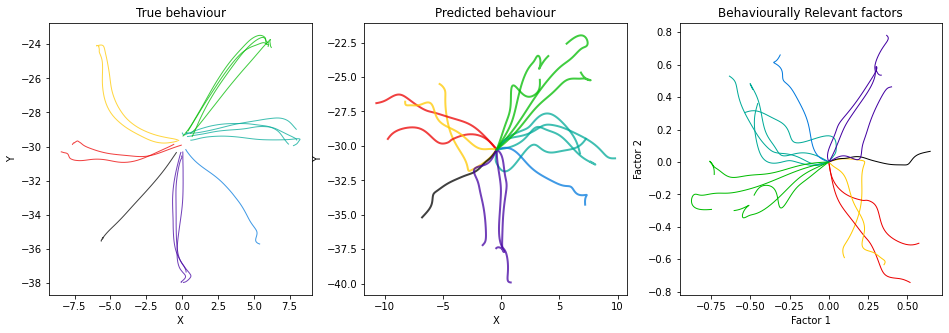

In [35]:
#Re-run inference when A is set to the identity. We purposefully do not update the other parameters to measure the effect that A has on the inferred latent states.
zPredTest, yPredTest, xPredTest = PSIDPredictForTrials(idSys4, smoothed_test_rates, YMean, ZMean, useKalmanSmoother=useKalmanSmoother)

factors = xPredTest
behaviour_means = zPredTest
rate_means = yPredTest

latents = np.asarray(factors)
dir_index = direction_index_test
ground_truth_behaviours = ground_truth_test_behaviours
predicted_behaviours = np.asarray(behaviour_means)

#Visualize results
plot_psid_2_factors(latents, dir_index, ground_truth_behaviours, predicted_behaviours);

In [36]:
#Evaluating the behaviour prediction
from sklearn.metrics import r2_score, mean_squared_error
trueCat = np.concatenate(ground_truth_test_behaviours)
predCat = np.concatenate(np.asarray(zPredTest))
print("Behaviour R2:", r2_score(trueCat, predCat))
print("Behaviour MSE:", mean_squared_error(trueCat, predCat))

Behaviour R2: 0.8834853821711706
Behaviour MSE: 1.984734165788755


The behaviour prediction using the Kalman filter is very high even when just fitting the model with behaviour! This baseline indicates that good behaviour prediction using the Kalman filter (which only takes as input the neural activity) does not mean that PSID is learning anything about the neural activity.

# Conclusion
**PSID learns non-informative neural dynamics (the state-transition matrix A) for this dataset.** Despite learning non-informative dynamics, the behaviour prediction is still pretty good which implies the Kalman filter is able to correct the predictions from PSID. Overall, PSID may not infer informative dynamics when the behaviour of interest is non-linear.